### VGG16


In [1]:
import gc
import time
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

import seaborn as sn

from tensorflow.python.client import device_lib


from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

from numba import cuda 

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
train_dataset_path = '../spectrograms_dataset_old/train/'
test_dataset_path = '../spectrograms_dataset_old/test/'

In [1]:
image_shape = (224, 224)
batch_size = 64
n_epochs = 50

input_shape = None
label_shape = None

In [5]:
def load_train_ds():
    train_ds = keras.utils.image_dataset_from_directory(
        directory=train_dataset_path,
        labels='inferred',
        label_mode='binary',
        seed=1337,
        shuffle=True,
        validation_split=validation_data_ratio,
        subset='training',
        batch_size=batch_size,
        image_size=image_shape)
    
    return train_ds

In [6]:
def load_validation_ds():
    validation_ds = keras.utils.image_dataset_from_directory(
        directory=train_dataset_path,
        labels='inferred',
        label_mode='binary',
        seed=1337,
        shuffle=True,
        validation_split=validation_data_ratio,
        subset='validation',
        batch_size=1,
        image_size=image_shape)
    
    return validation_ds

In [7]:
def load_test_ds():
    test_ds = keras.utils.image_dataset_from_directory(
        directory=test_dataset_path,
        labels='inferred',
        label_mode='binary',
        seed=1337,
        shuffle=True,
        batch_size=1,
        image_size=image_shape)
    
    return test_ds

In [8]:
def load_datasets():
    train_ds = load_train_ds()
    validation_ds = load_validation_ds()
    test_ds = load_test_ds()
    
    return train_ds, validation_ds, test_ds

In [9]:
def get_input_shape(ds):
    input_shape = None
    for ims, lbs in ds.take(1):
        input_shape = ims[0].shape
        label_shape = lbs[0].shape
        print('input shape:', input_shape)
        print('label shape:', label_shape)
        break
        
    return input_shape

In [10]:
def get_classes(ds):
    ds.class_names

In [11]:
def print_samples(ds):
    plt.figure(figsize=(10, 10))
    
    for images, labels in ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(ds.class_names[int(labels[i])])
            plt.axis("off")

In [12]:
# def preprocess(images, labels, preprocess_input):
# #     return tf.keras.applications.resnet50.preprocess_input(images), labels
#     return preprocess_input(images), labels 

# preprocess = lambda images, labels, preprocess_input: preprocess_input(images, labels)

In [13]:
# a = lambda x, y: (x*x, y)

# a(2, 3)

In [14]:
def preprocess_datasets(train_ds, validation_ds, test_ds, preprocess_input):
    ## Preprocessing input
    train_dataset = train_ds.map(lambda images, labels:( preprocess_input(images), labels))
    validation_dataset = validation_ds.map(lambda images, labels: (preprocess_input(images), labels))
    test_dataset = test_ds.map(lambda images, labels: (preprocess_input(images), labels))
    
    return train_dataset, validation_dataset, test_dataset

In [15]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [16]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [17]:
def build_model(input_shape, opt, base_model, flatten = True):
    base_model.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = base_model.output
    
    if flatten is True:
        top_model = Flatten(name="flatten")(top_model)
    else:
        top_model = GlobalAveragePooling2D(name="GlobalAveragePooling2D")(top_model)
            
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(512, activation='relu', name="fc1", 
                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.L2(1e-4),
                      activity_regularizer=regularizers.L2(1e-5))(top_model)
    
    top_model = Dropout(0.4)(top_model)
    
    output_layer = Dense(1, activation='sigmoid', name="prediction")(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=opt, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    print(model.summary())

    return model

In [29]:
def print_parameters(batch_size, lr, epochs):
    print('batch size:', batch_size)
    print('learning rate:', lr)
    print('epochs:', epochs)

In [30]:
# EarlyStopping
def early_stop(patience):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode='max', 
                           verbose=1)

In [31]:
def test_model(test_ds, model):
    predictions = np.array([])
    labels =  np.array([])

    for x, y in test_ds:
        predictions = np.concatenate([predictions, model.predict(x, verbose=0).reshape(1,-1)[0]])
        labels = np.concatenate([labels, np.array(y[0])])

    predictions = [0 if x < 0.5 else 1 for x in predictions]

    accuracy = accuracy_score(labels, predictions)
    print("Test Accuracy:", accuracy)
    
    f1score = f1_score(labels, predictions)
    print("F1 score:", f1score)
    

#     confusion_mtx = confusion_matrix(labels, predictions)

    ConfusionMatrixDisplay.from_predictions(labels, predictions)
    
    RocCurveDisplay.from_predictions(labels, predictions)
    
#     print(confusion_mtx)

#     ax = plt.axes()
#     sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
#     ax.set_title('Test Accuracy', size=14)
#     plt.show()

In [32]:
def run(datasets, input_shape, preprocess_input, base_model, flatten = True, lr = 0.001, epochs=100, patience=15):
    train_ds, validation_ds, test_ds = preprocess_datasets(*datasets, preprocess_input)
    
    print_parameters(batch_size, lr, epochs)
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model = build_model(input_shape, opt, base_model, flatten)
    
    history = model.fit(
        train_ds, 
        epochs=epochs, 
        validation_data=validation_ds, 
        #     callbacks=[tl_checkpoint_1, early_stop],
        callbacks=[early_stop(patience)],
        verbose=1)
    
    plot_accuracy(history)
    
    plot_loss(history)

    test_model(test_ds, model)
    
    del opt, model, history, train_ds, validation_ds, test_ds
    
    gc.collect()

## Load data

In [33]:
datasets = load_datasets()

Found 4616 files belonging to 2 classes.
Using 3693 files for training.
Found 4616 files belonging to 2 classes.
Using 923 files for validation.
Found 1155 files belonging to 2 classes.


In [34]:
input_shape = get_input_shape(datasets[0])

input shape: (224, 224, 3)
label shape: (1,)


# MODELS

### VGG16

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool 

Epoch 33/100
58/58 [==============================] - 144s 2s/step - loss: 0.4981 - accuracy: 0.8576 - val_loss: 0.3810 - val_accuracy: 0.9047
Epoch 34/100
58/58 [==============================] - 131s 2s/step - loss: 0.4958 - accuracy: 0.8581 - val_loss: 0.4371 - val_accuracy: 0.9112
Epoch 35/100
58/58 [==============================] - 144s 2s/step - loss: 0.5173 - accuracy: 0.8451 - val_loss: 0.4131 - val_accuracy: 0.9220
Epoch 36/100
58/58 [==============================] - 141s 2s/step - loss: 0.4881 - accuracy: 0.8494 - val_loss: 0.4010 - val_accuracy: 0.8743
Epoch 37/100
58/58 [==============================] - 140s 2s/step - loss: 0.4896 - accuracy: 0.8451 - val_loss: 0.3709 - val_accuracy: 0.9122
Epoch 38/100
58/58 [==============================] - 131s 2s/step - loss: 0.4832 - accuracy: 0.8549 - val_loss: 0.3918 - val_accuracy: 0.8808
Epoch 39/100
58/58 [==============================] - 141s 2s/step - loss: 0.4888 - accuracy: 0.8524 - val_loss: 0.3677 - val_accuracy: 0.9307

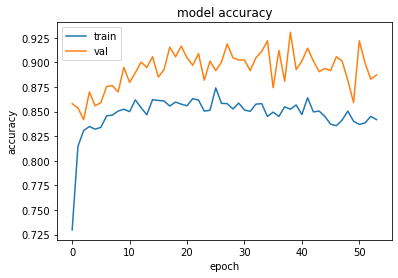

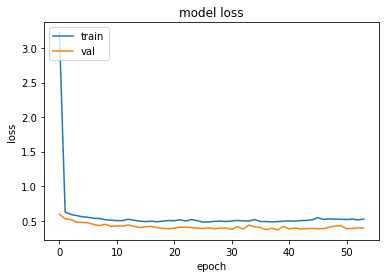

Test Accuracy: 0.9177489177489178
F1 score: 0.9208992506244795


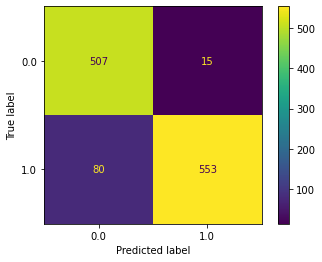

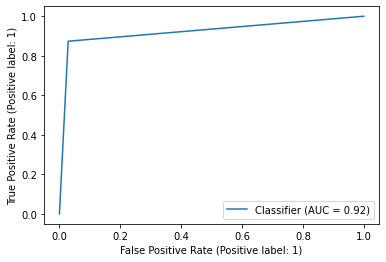

In [24]:
base_model = tf.keras.applications.VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.vgg16.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = True, lr = 0.001, epochs=100, patience=15)
#     True, 0.0001, 100, 15)

### VGG19

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_poo

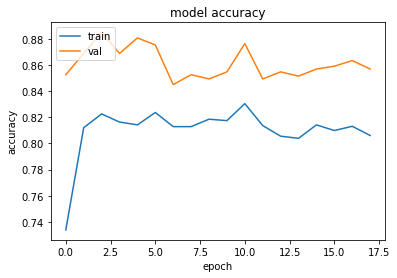

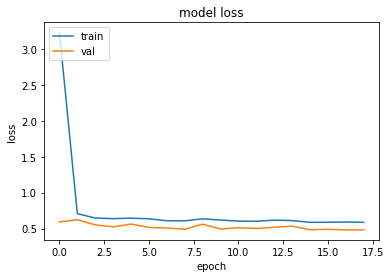

Test Accuracy: 0.8753246753246753
F1 score: 0.8777589134125637


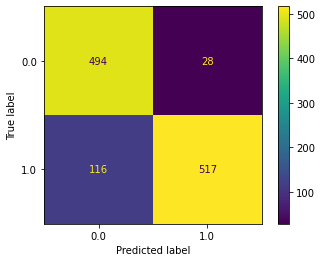

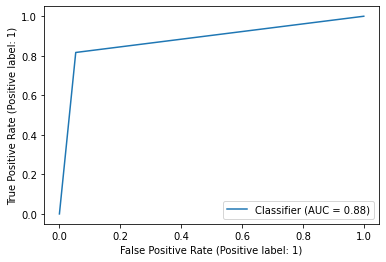

In [25]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.VGG19(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.vgg19.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = True, lr = 0.001, epochs=100, patience=15)

### ResNet50V2

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                           

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
          

                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalizat

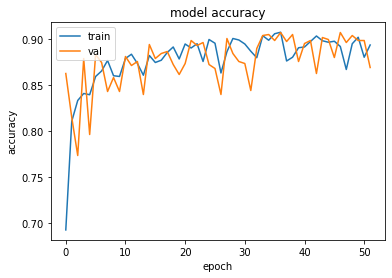

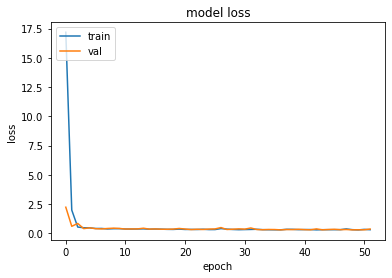

Test Accuracy: 0.8935064935064935
F1 score: 0.8994276369582993


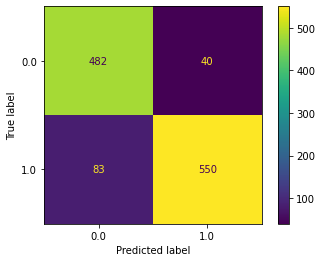

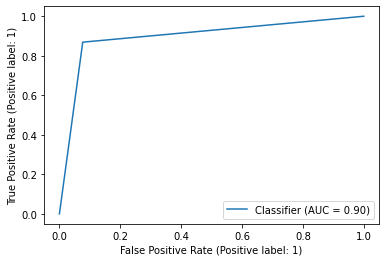

In [42]:
# batch size 64, lr 0.001, 

base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.resnet_v2.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=process, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

### InceptionResNetV2

In [27]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_406 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_406 (Batch  (None, 111, 111, 32  96         ['conv2d_406[0][0]']             
 Normalization)                 )             

 batch_normalization_411 (Batch  (None, 25, 25, 96)  288         ['conv2d_411[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_413 (Batch  (None, 25, 25, 64)  192         ['conv2d_413[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_416 (Batch  (None, 25, 25, 96)  288         ['conv2d_416[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_417 (Batch  (None, 25, 25, 64)  192         ['conv2d_417[0][0]']             
 Normaliza

 activation_427 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_427[0][0]']
                                                                                                  
 conv2d_425 (Conv2D)            (None, 25, 25, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_428 (Conv2D)            (None, 25, 25, 48)   13824       ['activation_427[0][0]']         
                                                                                                  
 batch_normalization_425 (Batch  (None, 25, 25, 32)  96          ['conv2d_425[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_428 (Batch  (None, 25, 25, 48)  144         ['conv2d_428[0][0]']             
 Normaliza

                                                                                                  
 activation_430 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_430[0][0]']
                                                                                                  
 activation_432 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_432[0][0]']
                                                                                                  
 activation_435 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_435[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_430[0][0]',         
                                                                  'activation_432[0][0]',         
                                                                  'activation_435[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_446 (Batch  (None, 25, 25, 48)  144         ['conv2d_446[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_443 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_443[0][0]']
                                                                                                  
 activation_446 (Activation)    (None, 25, 25, 48)   0           ['batch_normalization_446[0][0]']
                                                                                                  
 conv2d_442 (Conv2D)            (None, 25, 25, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_448[0][0]',         
                                                                  'activation_450[0][0]',         
                                                                  'activation_453[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 25, 25, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 25, 25, 320)  0           ['block35_6[0][0]']              
          

 activation_464 (Activation)    (None, 25, 25, 48)   0           ['batch_normalization_464[0][0]']
                                                                                                  
 conv2d_460 (Conv2D)            (None, 25, 25, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_462 (Conv2D)            (None, 25, 25, 32)   9216        ['activation_461[0][0]']         
                                                                                                  
 conv2d_465 (Conv2D)            (None, 25, 25, 64)   27648       ['activation_464[0][0]']         
                                                                                                  
 batch_normalization_460 (Batch  (None, 25, 25, 32)  96          ['conv2d_460[0][0]']             
 Normalization)                                                                                   
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 25, 25, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_475 (Conv2D)            (None, 25, 25, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_475 (Batch  (None, 25, 25, 32)  96          ['conv2d_475[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_475 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_475[0][0]']
          

 activation_481 (Activation)    (None, 12, 12, 384)  0           ['batch_normalization_481[0][0]']
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 12, 12, 320)  0          ['block35_10_ac[0][0]']          
 )                                                                                                
                                                                                                  
 mixed_6a (Concatenate)         (None, 12, 12, 1088  0           ['activation_478[0][0]',         
                                )                                 'activation_481[0][0]',         
                                                                  'max_pooling2d_10[0][0]']       
                                                                                                  
 conv2d_483 (Conv2D)            (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
          

 block17_2 (Lambda)             (None, 12, 12, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_491 (Conv2D)            (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_491 (Batch  (None, 12, 12, 128)  384        ['conv2d_491[0][0]']             
 Normalization)                                                                                   
          

 block17_4_ac (Activation)      (None, 12, 12, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_499 (Conv2D)            (None, 12, 12, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_499 (Batch  (None, 12, 12, 128)  384        ['conv2d_499[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_499 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_499[0][0]']
                                                                                                  
 conv2d_50

 conv2d_507 (Conv2D)            (None, 12, 12, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_507 (Batch  (None, 12, 12, 128)  384        ['conv2d_507[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_507 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_507[0][0]']
                                                                                                  
 conv2d_508 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_507[0][0]']         
                                                                                                  
 batch_normalization_508 (Batch  (None, 12, 12, 160)  480        ['conv2d_508[0][0]']             
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 activation_515 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_515[0][0]']
                                                                                                  
 conv2d_516 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_515[0][0]']         
                                                                                                  
 batch_normalization_516 (Batch  (None, 12, 12, 160)  480        ['conv2d_516[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_516 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_516[0][0]']
          

                                                                                                  
 conv2d_524 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_523[0][0]']         
                                                                                                  
 batch_normalization_524 (Batch  (None, 12, 12, 160)  480        ['conv2d_524[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_524 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_524[0][0]']
                                                                                                  
 conv2d_522 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_52

 batch_normalization_532 (Batch  (None, 12, 12, 160)  480        ['conv2d_532[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_532 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_532[0][0]']
                                                                                                  
 conv2d_530 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_533 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_532[0][0]']         
                                                                                                  
 batch_normalization_530 (Batch  (None, 12, 12, 192)  576        ['conv2d_530[0][0]']             
 Normaliza

 activation_540 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_540[0][0]']
                                                                                                  
 conv2d_538 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_541 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_540[0][0]']         
                                                                                                  
 batch_normalization_538 (Batch  (None, 12, 12, 192)  576        ['conv2d_538[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_541 (Batch  (None, 12, 12, 192)  576        ['conv2d_541[0][0]']             
 Normaliza

                                                                                                  
 conv2d_549 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_548[0][0]']         
                                                                                                  
 batch_normalization_546 (Batch  (None, 12, 12, 192)  576        ['conv2d_546[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_549 (Batch  (None, 12, 12, 192)  576        ['conv2d_549[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_546 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_546[0][0]']
          

 batch_normalization_554 (Batch  (None, 12, 12, 192)  576        ['conv2d_554[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_557 (Batch  (None, 12, 12, 192)  576        ['conv2d_557[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_554 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_554[0][0]']
                                                                                                  
 activation_557 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_557[0][0]']
                                                                                                  
 block17_1

                                                                                                  
 activation_562 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_562[0][0]']
                                                                                                  
 activation_564 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_564[0][0]']
                                                                                                  
 activation_567 (Activation)    (None, 12, 12, 288)  0           ['batch_normalization_567[0][0]']
                                                                                                  
 conv2d_563 (Conv2D)            (None, 5, 5, 384)    884736      ['activation_562[0][0]']         
                                                                                                  
 conv2d_565 (Conv2D)            (None, 5, 5, 288)    663552      ['activation_564[0][0]']         
          

 batch_normalization_575 (Batch  (None, 5, 5, 224)   672         ['conv2d_575[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_575 (Activation)    (None, 5, 5, 224)    0           ['batch_normalization_575[0][0]']
                                                                                                  
 conv2d_573 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_576 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_575[0][0]']         
                                                                                                  
 batch_normalization_573 (Batch  (None, 5, 5, 192)   576         ['conv2d_573[0][0]']             
 Normaliza

 conv2d_584 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_583[0][0]']         
                                                                                                  
 batch_normalization_581 (Batch  (None, 5, 5, 192)   576         ['conv2d_581[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_584 (Batch  (None, 5, 5, 256)   768         ['conv2d_584[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_581 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_581[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_589 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_589[0][0]']
                                                                                                  
 activation_592 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_592[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 5, 5, 448)    0           ['activation_589[0][0]',         
                                                                  'activation_592[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 

                                                                                                  
 block8_8_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_8_mixed[0][0]']         
                                                                                                  
 block8_8 (Lambda)              (None, 5, 5, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 5, 5, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_602 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_nor

                                                                                                  
 conv_7b_bn (BatchNormalization  (None, 5, 5, 1536)  4608        ['conv_7b[0][0]']                
 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 5, 5, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 GlobalAveragePooling2D (Global  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 AveragePooling2D)                                                                                
                                                                                                  
 flatten (Flatten)              (None, 1536)         0           ['GlobalAveragePooling2D[0][0]'] 
          

KeyboardInterrupt: 

### MobileNetV2

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

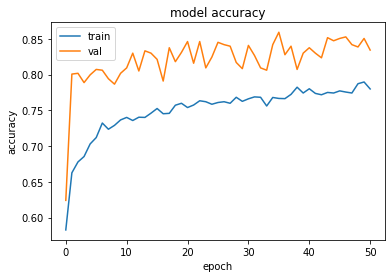

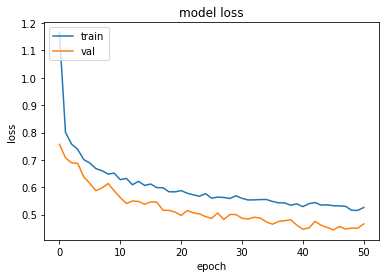

Test Accuracy: 0.8277056277056277
F1 score: 0.8237378210806023


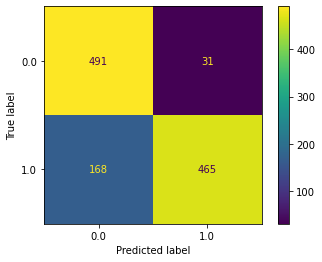

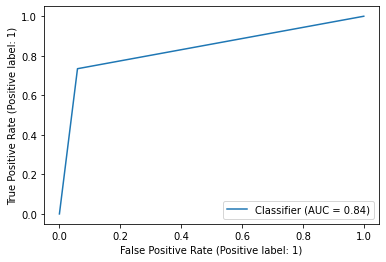

In [28]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

### DenseNet169

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_6[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                            

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 pool4_pool (AveragePooling2D)  (None, 7, 7, 640)    0           ['pool4_conv[0][0]']             
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['pool4_pool[0][0]']             
 ization)                                                                                         
                                                                                                  
 conv5_block1_0_relu (Activatio  (None, 7, 7, 640)   0           ['conv5_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 128)    81920       ['conv5_block1_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block5_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block5_0_relu[0][0]']    
                                                                                                  
 conv5_block5_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block5_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block9_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block9_1_relu[0][0]']    
                                                                                                  
 conv5_block9_concat (Concatena  (None, 7, 7, 928)   0           ['conv5_block8_concat[0][0]',    
 te)                                                              'conv5_block9_2_conv[0][0]']    
                                                                                                  
 conv5_block10_0_bn (BatchNorma  (None, 7, 7, 928)   3712        ['conv5_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block14_0_bn (BatchNorma  (None, 7, 7, 1056)  4224        ['conv5_block13_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block14_0_relu (Activati  (None, 7, 7, 1056)  0           ['conv5_block14_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block14_1_conv (Conv2D)  (None, 7, 7, 128)    135168      ['conv5_block14_0_relu[0][0]']   
                                                                                                  
 conv5_block14_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block14_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block18_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block18_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block18_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block18_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block18_1_relu[0][0]']   
                                                                                                  
 conv5_block18_concat (Concaten  (None, 7, 7, 1216)  0           ['conv5_block17_concat[0][0]',   
 ate)     

 conv5_block22_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block22_1_relu[0][0]']   
                                                                                                  
 conv5_block22_concat (Concaten  (None, 7, 7, 1344)  0           ['conv5_block21_concat[0][0]',   
 ate)                                                             'conv5_block22_2_conv[0][0]']   
                                                                                                  
 conv5_block23_0_bn (BatchNorma  (None, 7, 7, 1344)  5376        ['conv5_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block23_0_relu (Activati  (None, 7, 7, 1344)  0           ['conv5_block23_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block27_0_relu (Activati  (None, 7, 7, 1472)  0           ['conv5_block27_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, 7, 7, 128)    188416      ['conv5_block27_0_relu[0][0]']   
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block27_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block27_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block31_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block31_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block31_1_relu[0][0]']   
                                                                                                  
 conv5_block31_concat (Concaten  (None, 7, 7, 1632)  0           ['conv5_block30_concat[0][0]',   
 ate)                                                             'conv5_block31_2_conv[0][0]']   
                                                                                                  
 conv5_blo

Epoch 26/100
58/58 [==============================] - 129s 2s/step - loss: 0.6648 - accuracy: 0.6856 - val_loss: 0.5689 - val_accuracy: 0.7898
Epoch 27/100
58/58 [==============================] - 129s 2s/step - loss: 0.6692 - accuracy: 0.6981 - val_loss: 0.6097 - val_accuracy: 0.7822
Epoch 28/100
58/58 [==============================] - 129s 2s/step - loss: 0.6465 - accuracy: 0.7021 - val_loss: 0.5672 - val_accuracy: 0.7963
Epoch 29/100
58/58 [==============================] - 129s 2s/step - loss: 0.6507 - accuracy: 0.7124 - val_loss: 0.5549 - val_accuracy: 0.8299
Epoch 30/100
58/58 [==============================] - 129s 2s/step - loss: 0.6545 - accuracy: 0.6986 - val_loss: 0.5481 - val_accuracy: 0.7996
Epoch 31/100
58/58 [==============================] - 129s 2s/step - loss: 0.6490 - accuracy: 0.7011 - val_loss: 0.5586 - val_accuracy: 0.7811
Epoch 32/100
58/58 [==============================] - 129s 2s/step - loss: 0.6500 - accuracy: 0.7021 - val_loss: 0.5819 - val_accuracy: 0.8147

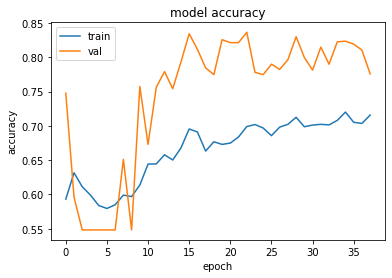

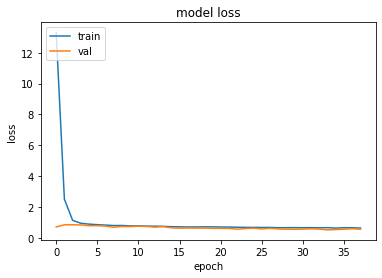

Test Accuracy: 0.8112554112554112
F1 score: 0.7996323529411765


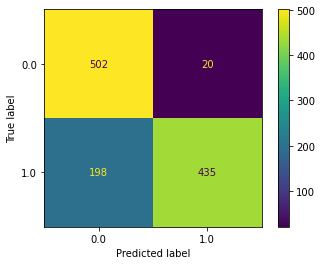

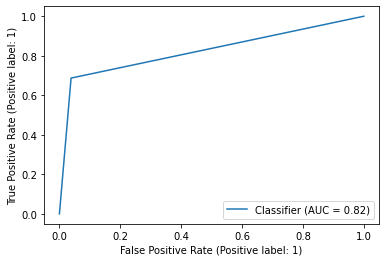

In [29]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.DenseNet169(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.densenet.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

### EfficientNetB2

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 

 block2a_expand_conv (Conv2D)   (None, 112, 112, 96  1536        ['block1b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 96  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 144)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_activation (Activation  (None, 28, 28, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 528)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 14, 14, 88)   46464       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 88)  352         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 88)   0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 120)  480        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 720)  86400       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 720)  2880       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 720)  0          ['block5b_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 14, 14, 720)  2880       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 14, 14, 720)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 14, 14, 720)  18000      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5d_b

 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 1248)  31200       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 1248)  4992        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 7, 7, 1248)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1248)        0           ['block6b_activation[0][0]']     
 agePoolin

                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1248)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1248)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1248)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 52)     64948       ['block6d_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1248)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 52)     64948       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1248)   66144       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1248)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
          

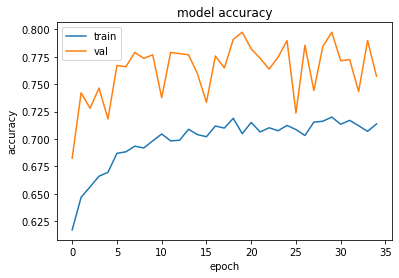

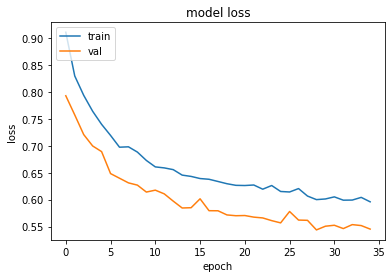

Test Accuracy: 0.7705627705627706
F1 score: 0.7588717015468608


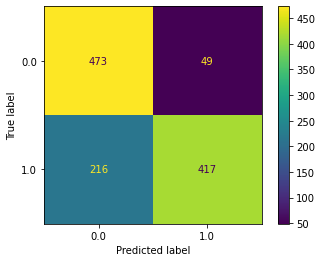

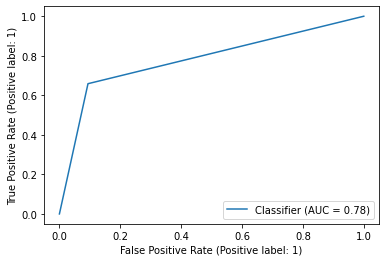

In [30]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.efficientnet.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

### Xception

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )           

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

Epoch 8/100
58/58 [==============================] - 108s 2s/step - loss: 0.7035 - accuracy: 0.6818 - val_loss: 0.7015 - val_accuracy: 0.7746
Epoch 9/100
58/58 [==============================] - 108s 2s/step - loss: 0.6972 - accuracy: 0.6799 - val_loss: 0.6653 - val_accuracy: 0.7844
Epoch 10/100
58/58 [==============================] - 108s 2s/step - loss: 0.6995 - accuracy: 0.6791 - val_loss: 0.6768 - val_accuracy: 0.8039
Epoch 11/100
58/58 [==============================] - 108s 2s/step - loss: 0.6806 - accuracy: 0.6870 - val_loss: 0.6432 - val_accuracy: 0.7898
Epoch 12/100
58/58 [==============================] - 108s 2s/step - loss: 0.6655 - accuracy: 0.7030 - val_loss: 0.6071 - val_accuracy: 0.7963
Epoch 13/100
58/58 [==============================] - 108s 2s/step - loss: 0.6553 - accuracy: 0.7092 - val_loss: 0.6028 - val_accuracy: 0.7996
Epoch 14/100
58/58 [==============================] - 108s 2s/step - loss: 0.6425 - accuracy: 0.7132 - val_loss: 0.5880 - val_accuracy: 0.8104
E

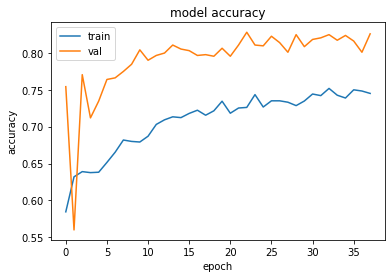

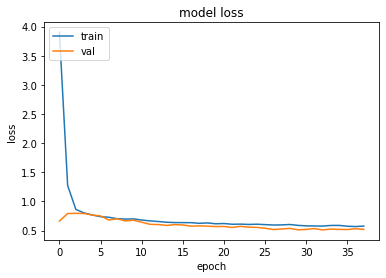

Test Accuracy: 0.8008658008658008
F1 score: 0.798598949211909


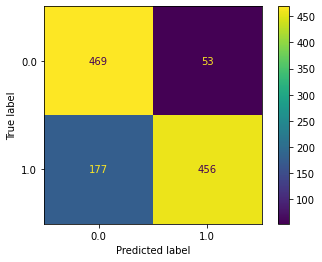

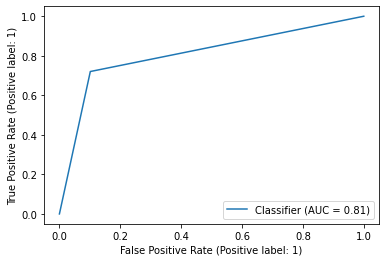

In [31]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.Xception(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.xception.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)

batch size: 64
learning rate: 0.001
epochs: 100
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )           

                                                                                                  
 separable_conv_1_pad_reduction  (None, 115, 115, 32  0          ['activation_210[0][0]']         
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_212 (Activation)    (None, 56, 56, 11)   0           ['reduction_add_1_stem_1[0][0]'] 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 56, 56, 11)  44          ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 add_12 (Add)                   (None, 56, 56, 11)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 56, 56, 11)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d (Cropping2D)        (None, 111, 111, 32  0           ['zero_padding2d_2[0][0]']       
                                )                                                                 
                                                                                                  
 reduction

 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 61, 61, 22)  0           ['activation_219[0][0]']         
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_221 (Activation)    (None, 56, 56, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction_add_1_stem_2 (Add)   (None, 28, 28, 22)   0           ['separable_conv_2_bn_reduction_l
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 reduction_right5_stem_2 (MaxPo  (None, 28, 28, 22)  0           ['reduction_pad_1_stem_2[0][0]'] 
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 57, 57, 44)  0           ['adjust_relu_1_0[0][0]']        
 D)                                                                                               
          

 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right2_
 ht2_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left5_0
 t5_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_227 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
          

 normal_concat_0 (Concatenate)  (None, 28, 28, 264)  0           ['adjust_bn_0[0][0]',            
                                                                  'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
                                                                  'normal_add_4_0[0][0]',         
                                                                  'normal_add_5_0[0][0]']         
                                                                                                  
 activation_236 (Activation)    (None, 28, 28, 88)   0           ['reduction_concat_stem_2[0][0]']
                                                                                                  
 activation_237 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_0[0][0]']        
          

 separable_conv_2_normal_left2_  (None, 28, 28, 44)  3036        ['activation_243[0][0]']         
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 44)  2332        ['activation_245[0][0]']         
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 44)  2332        ['activation_247[0][0]']         
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (Bat

 activation_258 (Activation)    (None, 28, 28, 44)   0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 44)  3036        ['activation_250[0][0]']         
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 44)  2332        ['activation_252[0][0]']         
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left2_  (None, 28, 28, 44)  3036        ['activation_254[0][0]']         
 2 (SeparableConv2D)                                                                              
          

 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 1_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_2[0][0]']                     
                                                                                                  
 normal_add_2_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 2_2[0][0]',                      
          

 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_263 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
                                                                                                  
 activation_265 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_3[0][0]']                     
                                                                                                  
 activation_267 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_3[0][0]']                      
          

 activation_273 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_3[0][0]']        
                                                                                                  
 activation_272 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_2[0][0]']        
                                                                                                  
 reduction_conv_1_reduce_4 (Con  (None, 28, 28, 88)  23232       ['activation_273[0][0]']         
 v2D)                                                                                             
                                                                                                  
 adjust_conv_projection_reduce_  (None, 28, 28, 88)  23232       ['activation_272[0][0]']         
 4 (Conv2D)                                                                                       
                                                                                                  
 reduction

                                                                 ]                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 88)  352         ['separable_conv_1_reduction_righ
 right2_reduce_4 (BatchNormaliz                                  t2_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 14, 14, 88)  9944        ['separable_conv_1_pad_reduction_
 ht3_reduce_4 (SeparableConv2D)                                  right3_reduce_4[0][0]']          
                                                                                                  
 separable_conv_1_reduction_lef  (None, 14, 14, 88)  8536        ['activation_282[0][0]']         
 t4_reduce

                                                                 eft4_reduce_4[0][0]',            
                                                                  'reduction_right5_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 cropping2d_2 (Cropping2D)      (None, 28, 28, 264)  0           ['zero_padding2d_4[0][0]']       
                                                                                                  
 reduction_concat_reduce_4 (Con  (None, 14, 14, 352)  0          ['reduction_add_2_reduce_4[0][0]'
 catenate)                                                       , 'reduction_add3_reduce_4[0][0]'
                                                                 , 'add_14[0][0]',                
                                                                  'reduction_add4_reduce_4[0][0]']
          

                                                                                                  
 activation_292 (Activation)    (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_5[0][0]']                     
                                                                                                  
 activation_294 (Activation)    (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 5_5[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_286[0][0]']         
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 adjust_bn_6 (BatchNormalizatio  (None, 14, 14, 88)  352         ['adjust_conv_projection_6[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn_1_6 (BatchNormalizat  (None, 14, 14, 88)  352         ['normal_conv_1_6[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_297 (Activation)    (None, 14, 14, 88)   0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 activation_299 (Activation)    (None, 14, 14, 88)   0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activatio

 t2_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_2_normal_right2_
 ht2_6 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 normal_left3_6 (AveragePooling  (None, 14, 14, 88)  0           ['normal_bn_1_6[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_6 (AveragePooling  (None, 14, 14, 88)  0           ['adjust_bn_6[0][0]']            
 2D)                                                                                              
          

                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left1_7
 t1_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_1_normal_right1_
 ht1_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left2_7
 t2_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 normal_add_4_7 (Add)           (None, 14, 14, 88)   0           ['normal_left4_7[0][0]',         
                                                                  'normal_right4_7[0][0]']        
                                                                                                  
 normal_add_5_7 (Add)           (None, 14, 14, 88)   0           ['separable_conv_2_bn_normal_left
                                                                 5_7[0][0]',                      
                                                                  'normal_bn_1_7[0][0]']          
                                                                                                  
 normal_concat_7 (Concatenate)  (None, 14, 14, 528)  0           ['adjust_bn_7[0][0]',            
                                                                  'normal_add_1_7[0][0]',         
                                                                  'normal_add_2_7[0][0]',         
          

                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_322[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 88)  8536        ['activation_324[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 88)  9944        ['activation_326[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 activation_333 (Activation)    (None, 14, 14, 176)  0           ['reduction_bn_1_reduce_8[0][0]']
                                                                                                  
 activation_335 (Activation)    (None, 14, 14, 176)  0           ['adjust_bn_reduce_8[0][0]']     
                                                                                                  
 separable_conv_1_pad_reduction  (None, 17, 17, 176)  0          ['activation_333[0][0]']         
 _left1_reduce_8 (ZeroPadding2D                                                                   
 )                                                                                                
                                                                                                  
 separable_conv_1_pad_reduction  (None, 19, 19, 176)  0          ['activation_335[0][0]']         
 _right1_reduce_8 (ZeroPadding2                                                                   
 D)       

 right3_reduce_8 (BatchNormaliz                                  t3_reduce_8[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 7, 7, 176)   704         ['separable_conv_1_reduction_left
 left4_reduce_8 (BatchNormaliza                                  4_reduce_8[0][0]']               
 tion)                                                                                            
                                                                                                  
 reduction_pad_1_reduce_8 (Zero  (None, 15, 15, 176)  0          ['reduction_bn_1_reduce_8[0][0]']
 Padding2D)                                                                                       
                                                                                                  
 separable

                                                                                                  
 adjust_conv_1_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_1_9[0][0]']    
                                                                                                  
 adjust_conv_2_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_2_9[0][0]']    
                                                                                                  
 activation_343 (Activation)    (None, 7, 7, 704)    0           ['reduction_concat_reduce_8[0][0]
                                                                 ']                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 7, 7, 176)    0           ['adjust_conv_1_9[0][0]',        
                                                                  'adjust_conv_2_9[0][0]']        
          

 separable_conv_2_normal_right2  (None, 7, 7, 176)   32560       ['activation_351[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 7, 7, 176)   32560       ['activation_353[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_9
 t1_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (Ba

 separable_conv_1_normal_left1_  (None, 7, 7, 176)   35376       ['activation_356[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 7, 7, 176)   32560       ['activation_358[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 7, 7, 176)   35376       ['activation_360[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right2  (None, 7, 7, 176)   32560       ['activation_362[0][0]']         
 _10 (Sepa

                                                                                                  
 normal_add_1_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
                                                                                                  
 normal_add_2_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 2_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_10[0][0]']                    
          

 activation_369 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activation_371 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t1_11[0][0]']                    
                                                                                                  
 activation_373 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 2_11[0][0]']                     
                                                                                                  
 activation_375 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
          

 activation_379 (Activation)    (None, 7, 7, 1056)   0           ['normal_concat_11[0][0]']       
                                                                                                  
 adjust_conv_projection_12 (Con  (None, 7, 7, 176)   185856      ['activation_378[0][0]']         
 v2D)                                                                                             
                                                                                                  
 normal_conv_1_12 (Conv2D)      (None, 7, 7, 176)    185856      ['activation_379[0][0]']         
                                                                                                  
 adjust_bn_12 (BatchNormalizati  (None, 7, 7, 176)   704         ['adjust_conv_projection_12[0][0]
 on)                                                             ']                               
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_1
 t1_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left2_1
 t2_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (B

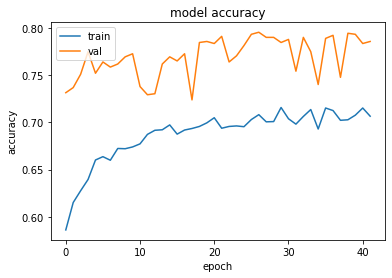

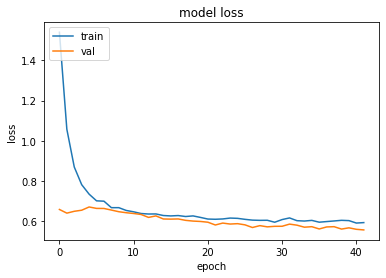

Test Accuracy: 0.78008658008658
F1 score: 0.803405572755418


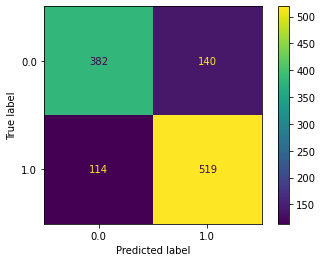

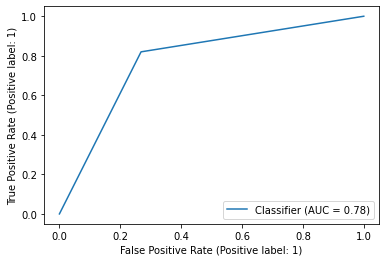

In [32]:
# batch size 64, lr 0.001, 
base_model = tf.keras.applications.nasnet.NASNetMobile(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

preprocess = tf.keras.applications.nasnet.preprocess_input

run(datasets=datasets, input_shape=input_shape, preprocess_input=preprocess, base_model=base_model, 
    flatten = False, lr = 0.001, epochs=100, patience=15)